In [1]:
from kafka import KafkaConsumer
from json import loads
import json
from time import sleep
import pandas as pd
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("C:\\Users\\Gjirafa\\Alberti\\AlbZa\\OpenSource\\ost-sm-change-detection\\streaming")  

from albert.influxdb_creds import *
from albert.model.load_model import *
from albert.kafka.kafka_topics import *
from albert.algorithms.kswin import *

In [2]:
def split_df(df):
    label = df.pop('attack')
    return df, label

In [3]:
model = get_model()

In [4]:
class HaiConsumer:
    def __init__(self, topic, bootstrap_servers):
        self.topic = topic
        self.bootstrap_servers = bootstrap_servers
        self.consumer = KafkaConsumer(
            self.topic,
            bootstrap_servers=self.bootstrap_servers,
            auto_offset_reset='earliest',
            enable_auto_commit=True,
            value_deserializer=lambda x: loads(x.decode('utf-8')))

    def consume(self):
        # Initialize KSWIN detector
        kswin_detector = KSWIN(window_size=30, alpha=0.01, kernel='linear')

        counter = 0
        # Perform change detection on the test set
        global change_points_kswin
        global accuracies
        global whole_df
        global whole_labels
        global true_positives_kswin
        global false_positives_kswin
        global time_steps
        global accuracies_to_save

        change_points_kswin = []
        accuracies = []
        whole_df = pd.DataFrame()
        whole_labels = pd.Series()
        true_positives_kswin = 0
        false_positives_kswin = 0

        detections = 0 # Actual detections (one per attack)
        false_positive = 0 # False alarms (with attack_label == "normal")

        # Lists to store time steps
        time_steps = []
        accuracies_to_save = []

        # write to file
        with influxdb_client.InfluxDBClient(url=url, token=token, org=org) as client:
            write_api = client.write_api(write_options=SYNCHRONOUS)
            for i, message in enumerate(self.consumer):
                message = message.value
                # selected_columns = {key: value for key, value in message.items() if key in columns_to_scale_and_monitor}
                df = pd.DataFrame([message])
                x_i, y_i = split_df(df)
                x_i = x_i.iloc[0:1]

                whole_df = pd.concat([whole_df, x_i], ignore_index=True)
                whole_labels = pd.concat([whole_labels, y_i], ignore_index=True)

                # Predict using the RandomForest model
                pred = model.predict(x_i)

                change_detected = 0
                # Check for a change point using KSWIN
                if kswin_detector.add_element(pred):
                    change_points_kswin.append(i)
                    change_detected = 1
                    if int(y_i) == 0:
                        false_positive += 1
                    else:
                        detections += 1

                total_negatives = whole_labels.iloc[:i + 1].value_counts().get(0, 0)
                false_positive = false_positive / total_negatives if total_negatives > 0 else 0
                
                p = influxdb_client.Point("HAI_ChangeDetection_KSWIN_1").field('current_state', int(y_i)).field('change_detected', change_detected)
                write_api.write(bucket, org, p)
                
                # Calculate accuracy at each step
                accuracy = model.score(whole_df.iloc[:i + 1], whole_labels.iloc[:i + 1])
                accuracies.append(accuracy)
                acc_to_save = 0
                if accuracy >= 0.4:
                    acc_to_save = 1
                else:
                    acc_to_save = 0

                accuracies_to_save.append(acc_to_save)
                
                p = influxdb_client.Point("HAI_ChangeDetection_KSWIN_1").field('predicted_val_acc_to_save', int(acc_to_save))
                write_api.write(bucket, org, p)
                
                time_steps.append(i)

                
            client.close()


In [5]:
consumer = HaiConsumer(topic_preprocessor, bootstrap_servers)
consumer.consume()

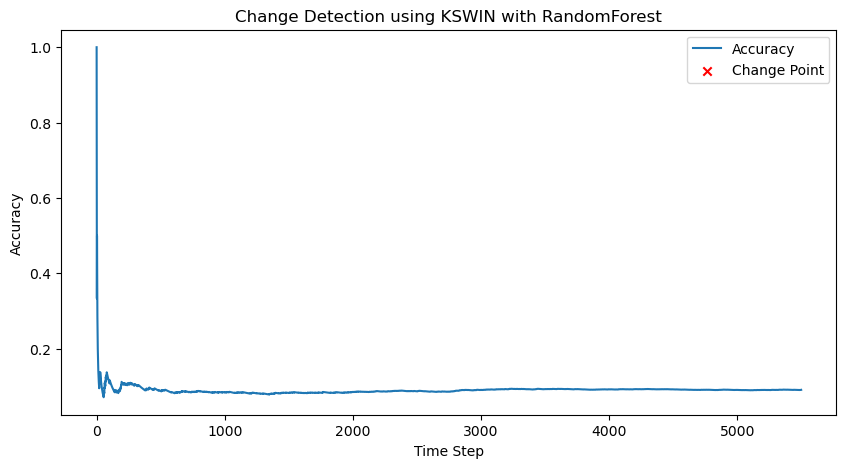

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(len(whole_df)), accuracies, label='Accuracy')
plt.scatter(change_points_kswin, [accuracies[i] for i in change_points_kswin], color='red', marker='x', label='Change Point')
plt.title('Change Detection using KSWIN with RandomForest')
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

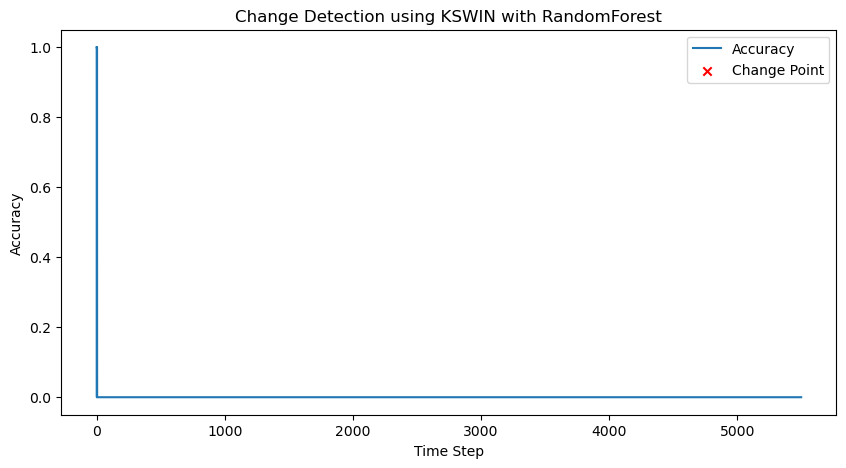

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(len(whole_df)), accuracies_to_save, label='Accuracy')
plt.scatter(change_points_kswin, [accuracies_to_save[i] for i in change_points_kswin], color='red', marker='x', label='Change Point')
plt.title('Change Detection using KSWIN with RandomForest')
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()